In [1]:

packages <- c(
    "ggplot2", 
    "dplyr", 
    "patchwork",
    "ggExtra",
    "VennDiagram"
)
for (pkg in packages) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                pkg,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}
source("../../utils/r_themes.r")

In [2]:
lm_results_file_path <- file.path(
    "../results/all_features_beta_df.parquet"
)
plot_save_dir <- file.path(
    "../figures"
)
if (!dir.exists(plot_save_dir)) {
    dir.create(plot_save_dir, recursive = TRUE)
}
plot_file_path <- file.path(
    plot_save_dir,
    "lm_coefficients_colored_by_feature_type_CP.png"
)

plot_file_path2 <- file.path(
    plot_save_dir,
    "lm_coefficients_colored_by_channel_CP.png"
)
lm_coeff_df <- arrow::read_parquet(lm_results_file_path)
# shuffle the row order for plotting purposes
lm_coeff_df <- lm_coeff_df %>%
    dplyr::mutate(
        row_id = 1:nrow(lm_coeff_df)
    ) %>%
    dplyr::arrange(dplyr::desc(row_id)) %>%
    dplyr::select(-row_id)
# drop all rows that have featurizer_id of scDINO
lm_coeff_df <- lm_coeff_df %>%
    dplyr::filter(featurizer_id != "scDINO")
head(lm_coeff_df)

beta,p_value,variate,r2,feature,Compartment,Feature_type,Channel,Channel2,featurizer_id,feature_number,Measurement,p_value_corrected
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
0.0072549891,5.420792e-54,Dose,0.52481556,Nuclei_Texture_SumAverage_DNA_3_00_256_CP,Nuclei,Texture,DNA,None,CP,NA,NA,6.363302e-53
0.0003960006,7.437462e-01,Cell count,0.52481556,Nuclei_Texture_SumAverage_DNA_3_00_256_CP,Nuclei,Texture,DNA,None,CP,NA,NA,7.960555e-01
0.0462221996,1.078661e-17,Time,0.52481556,Nuclei_Texture_SumAverage_DNA_3_00_256_CP,Nuclei,Texture,DNA,None,CP,NA,NA,4.062478e-17
-0.3630061704,1.022369e-01,const,0.52481556,Nuclei_Texture_SumAverage_DNA_3_00_256_CP,Nuclei,Texture,DNA,None,CP,NA,NA,1.490513e-01
-0.0018694576,3.662695e-07,Dose,0.07596228,Nuclei_Texture_SumAverage_CL_561_3_01_256_CP,Nuclei,Texture,CL 561,None,CP,NA,NA,9.767187e-07
-0.0002105771,8.480739e-01,Cell count,0.07596228,Nuclei_Texture_SumAverage_CL_561_3_01_256_CP,Nuclei,Texture,CL 561,None,CP,NA,NA,8.813706e-01


In [3]:
lm_coeff_df$log10p_value <- -log10(lm_coeff_df$p_value)
# remove the const from the variate column
lm_coeff_df <- lm_coeff_df %>%
    filter(
        !grepl("const", variate)
    )
# if the log10p is inf then set to the max value
lm_coeff_df$log10p_value[is.infinite(lm_coeff_df$log10p_value)] <- max(
    lm_coeff_df$log10p_value[!is.infinite(lm_coeff_df$log10p_value)]
)

lm_coeff_df$Feature_type <- gsub(
    "RadialDistribution",
    "Radial\nDistibution",
    lm_coeff_df$Feature_type
)
head(lm_coeff_df)

beta,p_value,variate,r2,feature,Compartment,Feature_type,Channel,Channel2,featurizer_id,feature_number,Measurement,p_value_corrected,log10p_value
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
0.0072549891,5.420792e-54,Dose,0.52481556,Nuclei_Texture_SumAverage_DNA_3_00_256_CP,Nuclei,Texture,DNA,None,CP,NA,NA,6.363302e-53,53.26593724
0.0003960006,7.437462e-01,Cell count,0.52481556,Nuclei_Texture_SumAverage_DNA_3_00_256_CP,Nuclei,Texture,DNA,None,CP,NA,NA,7.960555e-01,0.12857522
0.0462221996,1.078661e-17,Time,0.52481556,Nuclei_Texture_SumAverage_DNA_3_00_256_CP,Nuclei,Texture,DNA,None,CP,NA,NA,4.062478e-17,16.96711505
-0.0018694576,3.662695e-07,Dose,0.07596228,Nuclei_Texture_SumAverage_CL_561_3_01_256_CP,Nuclei,Texture,CL 561,None,CP,NA,NA,9.767187e-07,6.43619921
-0.0002105771,8.480739e-01,Cell count,0.07596228,Nuclei_Texture_SumAverage_CL_561_3_01_256_CP,Nuclei,Texture,CL 561,None,CP,NA,NA,8.813706e-01,0.07156628
-0.0096241705,3.968324e-02,Time,0.07596228,Nuclei_Texture_SumAverage_CL_561_3_01_256_CP,Nuclei,Texture,CL 561,None,CP,NA,NA,6.460088e-02,1.40139288


In [4]:
print(paste0("Total number of models trained: ", nrow(lm_coeff_df)/n_distinct(lm_coeff_df$variate)))

[1] "Total number of models trained: 800"


Warning message:
“Duplicated `override.aes` is ignored.”
Warning message:
“Duplicated `override.aes` is ignored.”


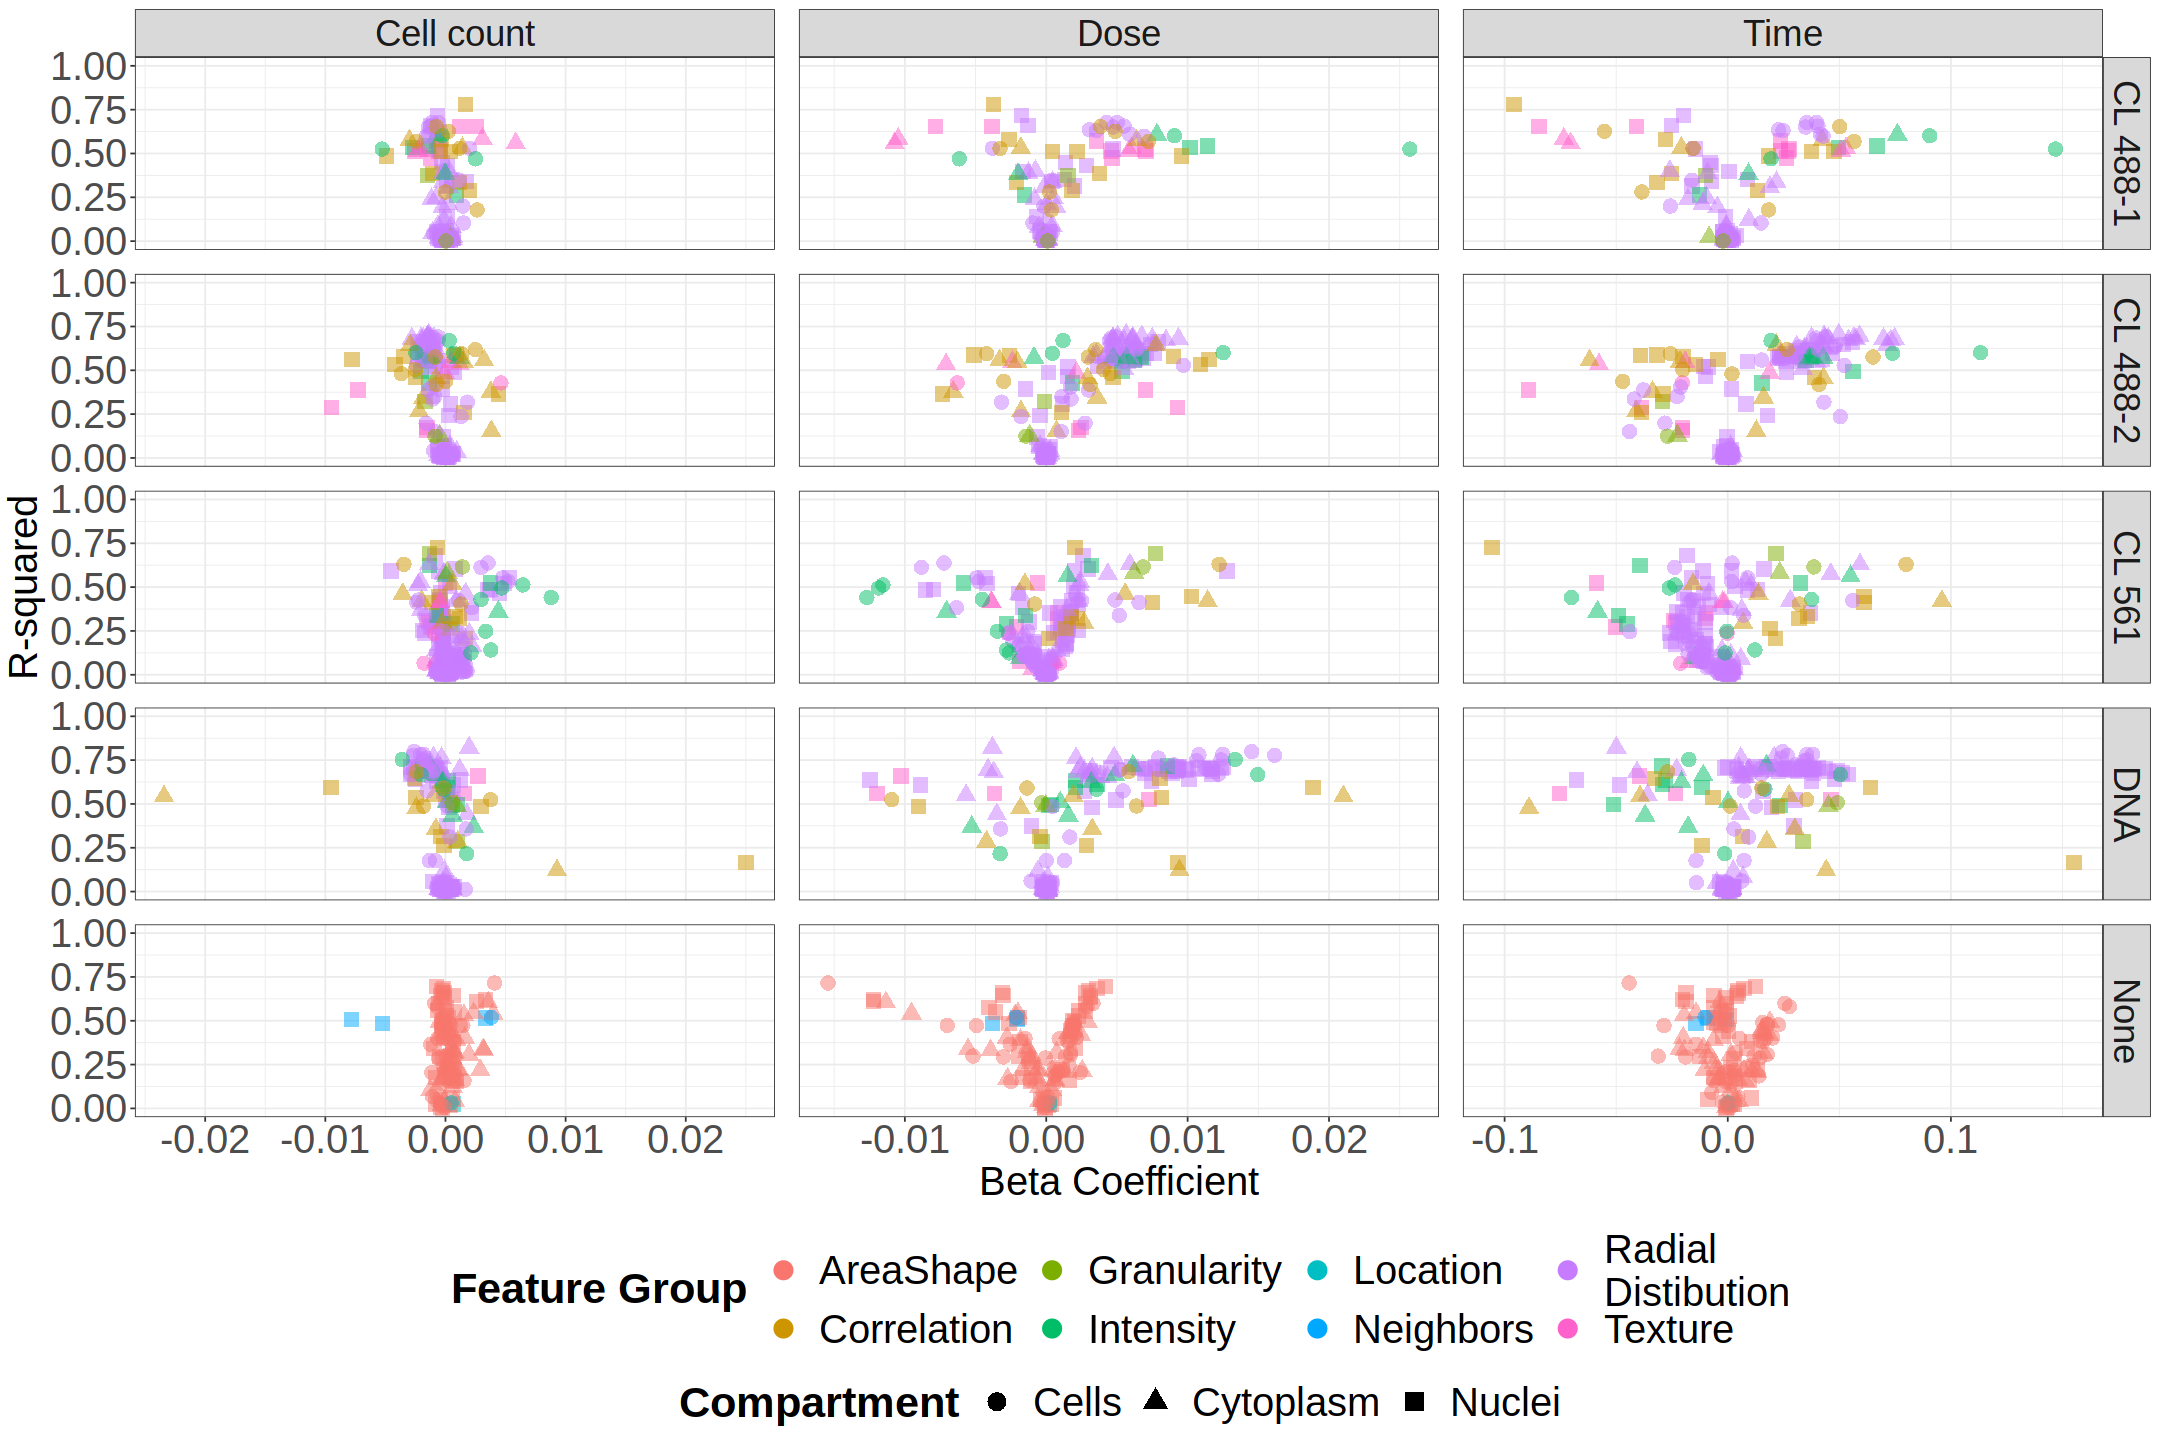

In [5]:
width <- 18
height <- 12
options(repr.plot.width = width, repr.plot.height = height)
lm_coeff_plot <- (
    ggplot(lm_coeff_df, aes(
        x = beta, 
        y = r2, 
        fill = Feature_type, 
        )
    )
    + geom_point(
        aes(
            color = Feature_type,
            shape = Compartment
        ),
        alpha = 0.5,
        stroke = 0.5,
        size = 4
    )
    + labs(
        x = "Beta Coefficient",
        y = "R-squared",
    )
    + plot_themes
    + guides(
        fill = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Feature Group",
            # title position
            # title.position = "top",
            # title.hjust = 0.5,
            title.theme = element_text(face = "bold", size = font_size + 2),
        ),
        color = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Feature Group",
            # title position
            # title.position = "top",
            # title.hjust = 0.5,
            title.theme = element_text(face = "bold", size = font_size + 2),

        ),
    
        shape = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Compartment",
            # title.position = "top",
            # title.hjust = 0.5,
            title.theme = element_text(face = "bold", size = font_size + 2),


        )
    )
    + ylim(0,1)
    + facet_grid(
        Channel ~ variate,
        scales = "free",

    )

    + theme(
        panel.spacing = unit(1, "lines"),

        legend.box = "vertical",  # Stack legends vertically
        # legend.box.just = "left"  # Align legends to the left
    )
)
ggsave(
    filename = plot_file_path,
    plot = lm_coeff_plot,
    device = "png",
    width = width,
    height = height,
    dpi = 600,
    units = "in",
)
lm_coeff_plot     


Warning message:
“Duplicated `override.aes` is ignored.”
Warning message:
“Duplicated `override.aes` is ignored.”


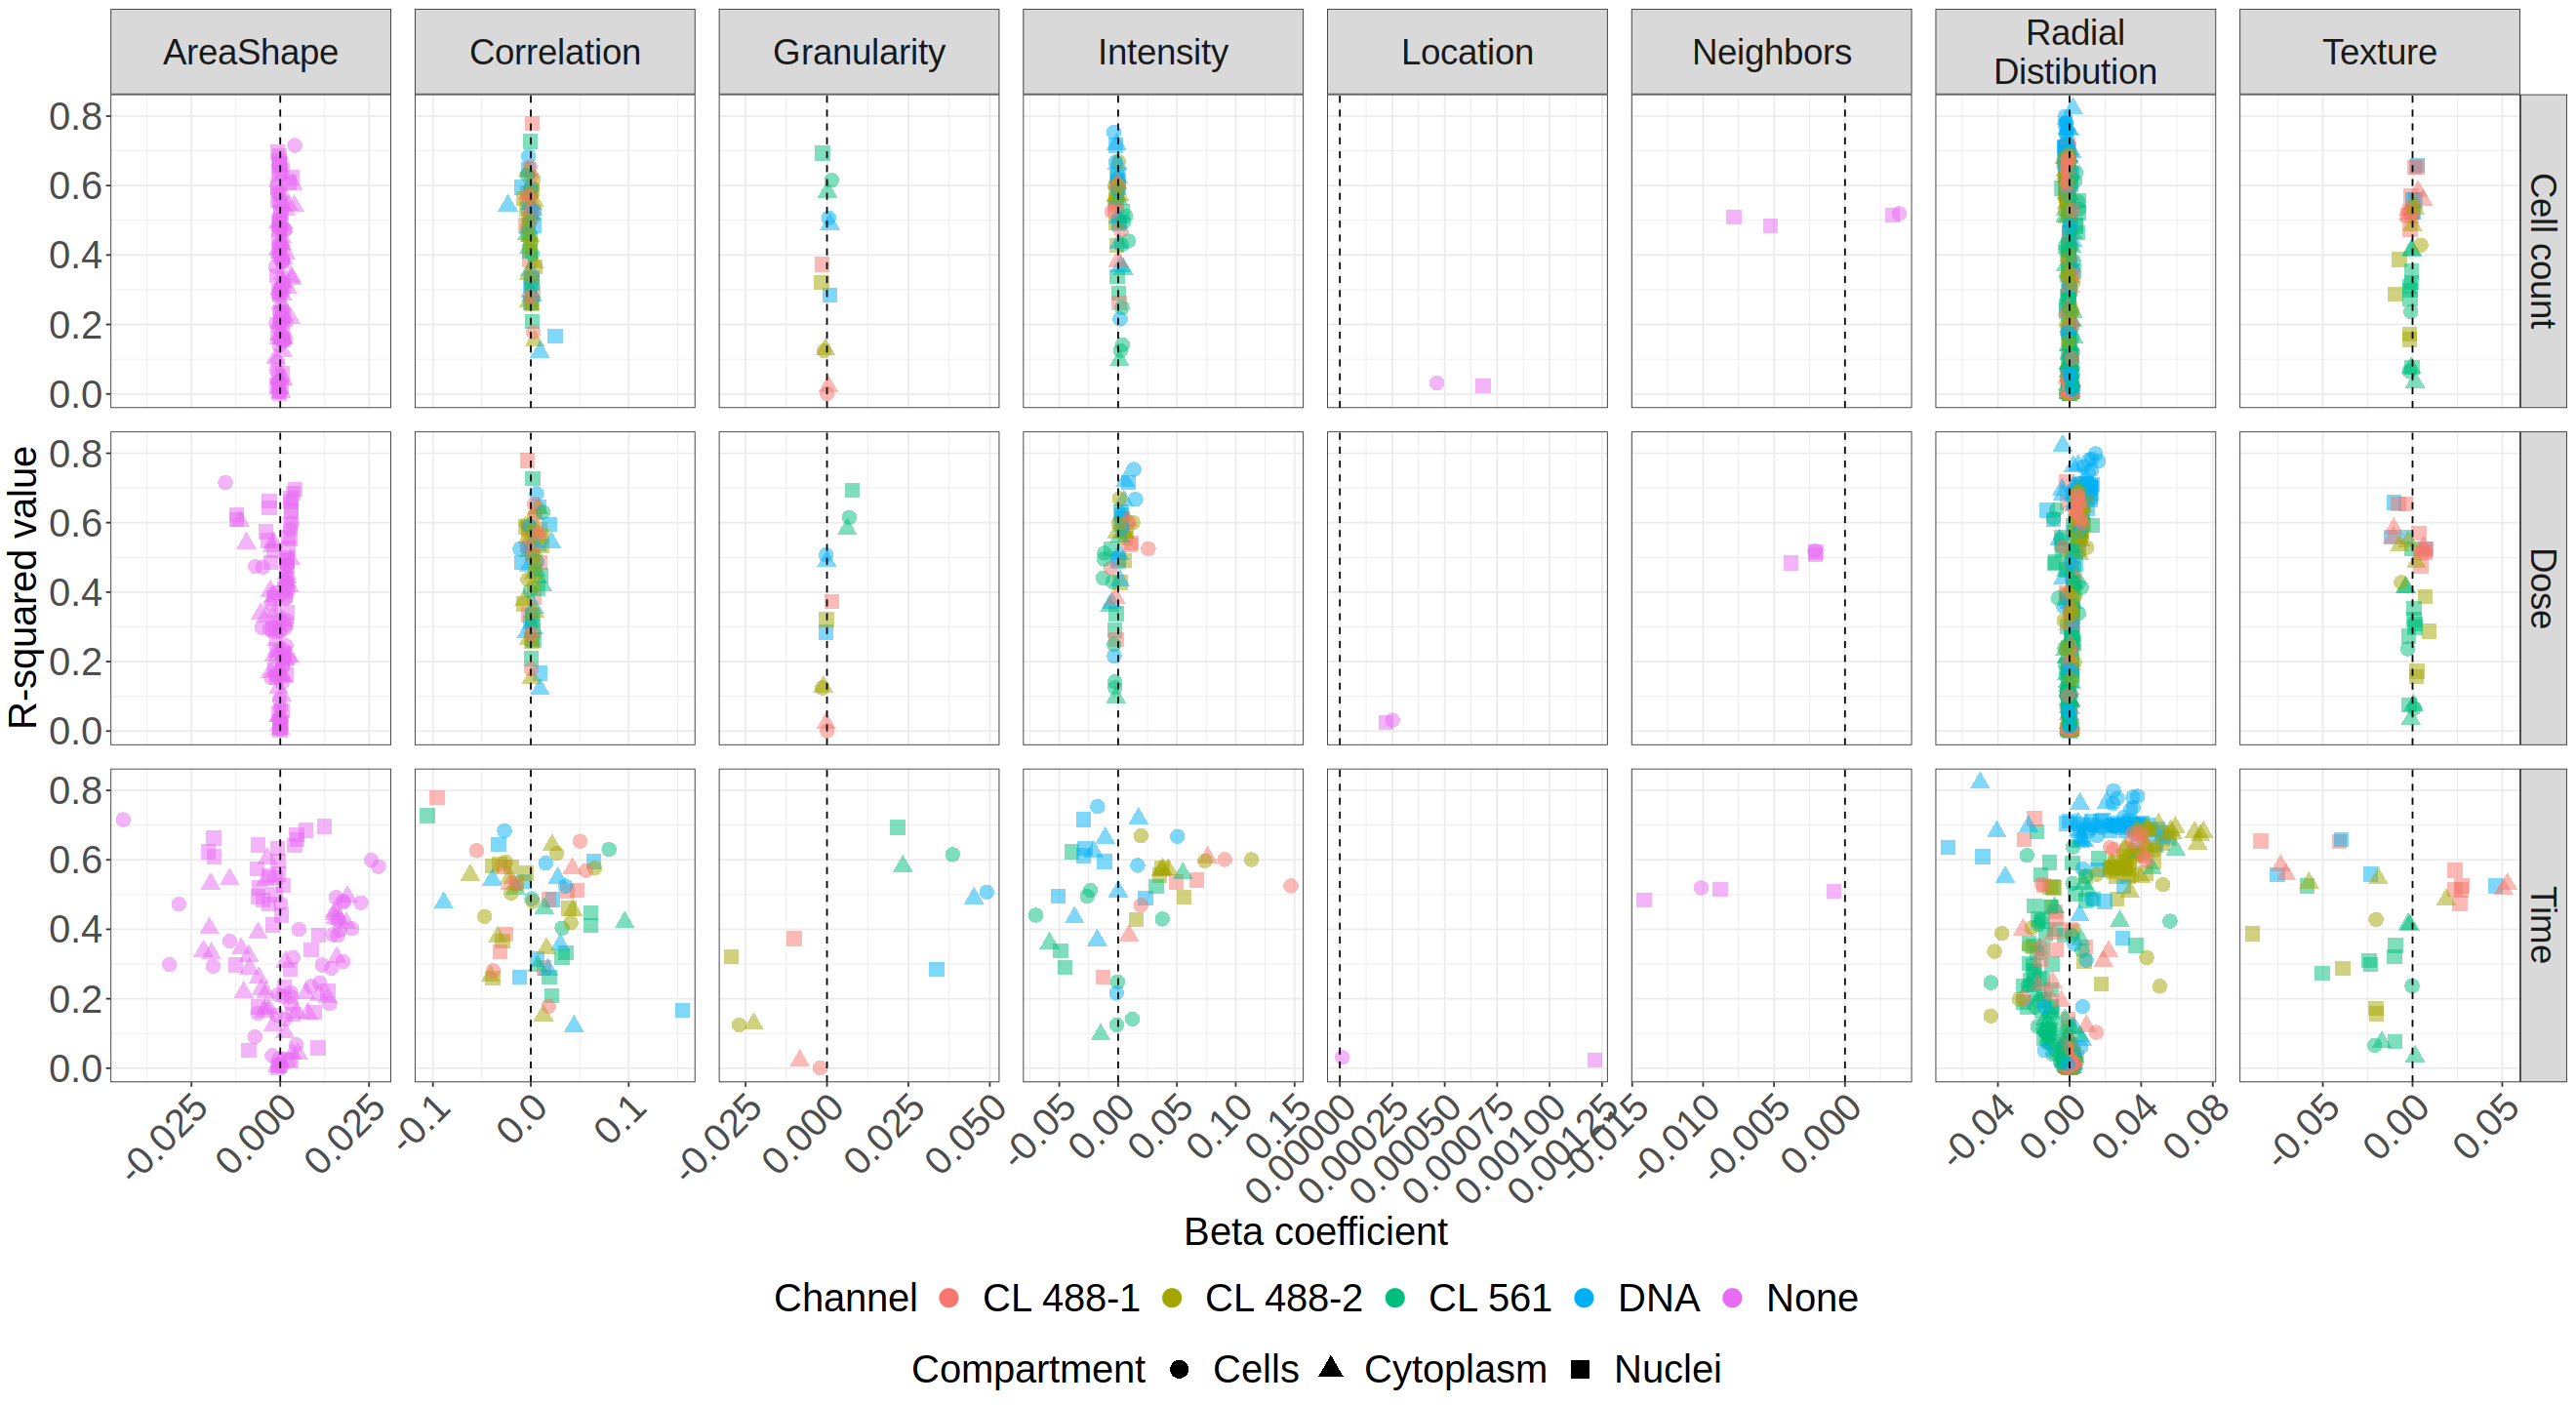

In [6]:
width <- 22
height <- 12
options(repr.plot.width = width, repr.plot.height = height)
lm_coeff_plot2 <- (
    ggplot(lm_coeff_df, aes(
        x = beta, 
        y = r2, 
        fill = Channel, 
        )
    )
    + geom_point(
        aes(
            color = Channel,
            shape = Compartment
        ),
        alpha = 0.5,
        stroke = 0.5,
        size = 4
    )
    + labs(
        x = "Beta coefficient",
        y = "R-squared value"
    )
    + plot_themes
    + guides(
        fill = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Channel"
        ),
        color = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Channel"
        ),
    
        shape = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Compartment"
        )
    )
    + facet_grid(
        variate ~ Feature_type,
        scales = "free",

    )
    + geom_vline(
        xintercept = 0,
        linetype = "dashed",
    )
        + theme(
        panel.spacing = unit(1, "lines"),  # Adjust spacing between facets
        # x ticks rotation
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)
        
    )

    + theme(
        panel.spacing = unit(1, "lines"),

        legend.box = "vertical",  # Stack legends vertically
        # legend.box.just = "left"  # Align legends to the left
    )

)
ggsave(
    filename = plot_file_path2,
    plot = lm_coeff_plot2,
    device = "png",
    width = width,
    height = height,
    dpi = 600,
    units = "in",
)
lm_coeff_plot2   
